# Lukas-Kanade Optical Flow Algorithm

In [ ]:
import numpy as np
from scipy import signal

In [ ]:
def LK_optical_flow(img_1, img_2, window_size, t=0.1):
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])
    w = int(window_size/2)
    img_1 = img_1 / 255.
    img_2 = img_2 / 255.
    shape = np.shape(img_1)
    fx = signal.convolve2d(img_1, kernel_x, boundary='symm', mode='same')
    fy = signal.convolve2d(img_1, kernel_y, boundary='symm', mode='same')
    ft = signal.convolve2d(img_2, kernel_t, boundary='symm', mode='same') - signal.convolve2d(img_1, kernel_t, boundary='symm', mode='same')
    u = np.zeros(img_1.shape)
    v = np.zeros(img_1.shape)

    for i in range(w, img_1.shape[0]-w):
        for j in range(w, img_1.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            A=np.array([Ix, Iy]).T
            A_ = np.dot(A.T, A)
            A_inv = np.linalg.pinv(A_)
            b=np.array([It]).T
            b_ = np.dot(A.T, b)
            
            if np.linalg.matrix_rank(np.dot(A.T, A)) == 2:
                nu = np.dot(A_inv, b_)
                u[i,j]=nu[0]
                v[i,j]=nu[1]
            else:
                u[i,j]=0
                v[i,j]=0
    plt.imshow(img_1,cmap = cm.gray)
    plt.quiver(u,v, scale_units='xy', angles='xy',width = 0.001, color='red', minshaft = 1, minlength =0)
    plt.show()

In [281]:
A = cv2.cvtColor(cv2.imread('sphere1.jpg'), cv2.COLOR_RGB2GRAY)
B = cv2.cvtColor(cv2.imread('sphere2.jpg'), cv2.COLOR_RGB2GRAY)

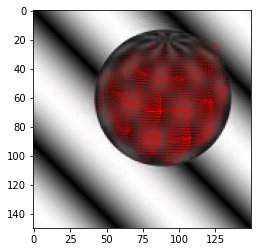

In [265]:
LK_optical_flow(A, B, 10)

## Gaussian Pyramid

In [307]:
def LK_optical_flow(img_1, img_2, window_size,t=0.1):
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])
    w = int(window_size/2)
    img_1 = img_1 / 255.
    img_2 = img_2 / 255.
    shape = np.shape(img_1)
    fx = signal.convolve2d(img_1, kernel_x, boundary='symm', mode='same')
    fy = signal.convolve2d(img_1, kernel_y, boundary='symm', mode='same')
    ft = signal.convolve2d(img_2, kernel_t, boundary='symm', mode='same') - signal.convolve2d(img_1, kernel_t, boundary='symm', mode='same')
    u = np.zeros(img_1.shape)
    v = np.zeros(img_1.shape)

    for i in range(w, img_1.shape[0]-w):
        for j in range(w, img_1.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            A=np.array([Ix, Iy]).T
            A_ = np.dot(A.T, A)
            A_inv = np.linalg.pinv(A_)
            b=np.array([It]).T
            b_ = np.dot(A.T, b)
            
            if np.linalg.matrix_rank(np.dot(A.T, A)) == 2:
                nu = np.dot(A_inv, b_)
                u[i,j]=nu[0]
                v[i,j]=nu[1]
            else:
                u[i,j]=0
                v[i,j]=0
                
    return u,v

In [425]:
def reduce(image, levels):
    result = np.copy(image)
    for i in range(levels-1):
        result = cv2.pyrDown(result)
    return result
     
def expand(image):
    return cv2.pyrUp(np.copy(image))

In [418]:
def LK_warping(img1, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w) ##u
    flow[:,:,1] += np.arange(h)[:,np.newaxis] ##v
    mask = cv2.remap(img1, flow, None, cv2.INTER_LINEAR)
    return mask

In [449]:
def LK_create_pyramid(img_1, img_2, window, levels):
    shape = np.shape(img_1)  
    new_A = []
    top_1_1 = reduce(img_1, levels)
    top_2_1 = reduce(img_2, levels)
    top_1_2 = reduce(img_1, levels -1)
    top_2_2 = reduce(img_2, levels -1)
    u, v = LK_optical_flow(top_1_1, top_2_1, window)
    flow = expand(np.dstack((u,v)))
    new_A = LK_warping(np.float32(top_2_2), np.float32(flow))
    print('first', top_1_1.shape)
    plt.imshow(top_1_1,cmap = cm.gray)
    plt.quiver(u, v, color='red')
    plt.show()
    
    top_1_1 = reduce(img_1, levels -1)
    top_2_1 = reduce(img_2, levels -1)
    top_1_2 = reduce(img_1, levels -2)
    top_2_2 = reduce(img_2, levels -2)
    u, v = LK_optical_flow(top_1_1, top_2_1, window)
    flow = expand(np.dstack((u,v)))
    new_A = LK_warping(np.float32(top_2_2), np.float32(flow))
    print('second', top_1_1.shape)
    plt.imshow(top_1_1,cmap = cm.gray)
    plt.quiver(u, v, color='red')
    plt.show()
    
    top_1_1 = reduce(img_1, levels -2)
    top_2_1 = reduce(img_2, levels -2)
    top_1_2 = reduce(img_1, levels -3)
    top_2_2 = reduce(img_2, levels -3)
    u, v = LK_optical_flow(top_1_1, top_2_1, window)
    flow = expand(np.dstack((u,v)))
    new_A = LK_warping(np.float32(top_2_2), np.float32(flow))
    print('third', top_1_1.shape)
    plt.imshow(top_1_1,cmap = cm.gray)
    plt.quiver(u, v, color='red')
    plt.show()

first (38, 38)


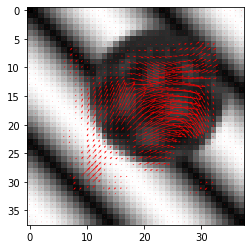

second (75, 75)


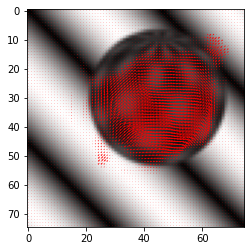

third (150, 150)


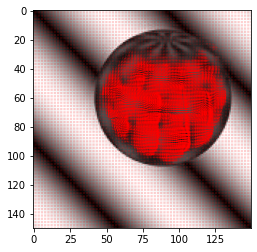

In [450]:
LK_create_pyramid(A, B, 10, 3)